In [27]:
import tushare as ts
import pandas as pd
import numpy as np
#数据选取2015到2018三年的数据
xshg_df=ts.get_hist_data('sh')
xshg_df.sort_index(ascending=True,inplace=True)
#提取原列名，昨日数据的列名
c0=xshg_df.columns.tolist()
#将
def adany(s):
    def ad0(r):
        rr=str(r)
        ss=str(s)
        a=rr+ss
        return a

    return ad0
#重新命名前天和大前天的数据
f1=adany(1)
c1=list(map(f1,c0))

f2=adany(2)
c2=list(map(f2,c0))

#将3个表合并
a=xshg_df.iloc[:-2,:]
a.reset_index(drop=True,inplace=True)

a1=xshg_df.iloc[1:-1,:]
a1.reset_index(drop=True,inplace=True)
a1.columns=c1

a2=xshg_df.iloc[2:,:]
a2.reset_index(drop=True,inplace=True)
a2.columns=c2
train=pd.concat([a,a1,a2],axis=1)



# #计算均线
# for i in np.arange(50,train.shape[0]):
#     train.loc[i,'ma5']=np.mean(train.loc[i-5:i,'close2'])
#     train.loc[i,'ma10']=np.mean(train.loc[i-10:i,'close2'])
#     train.loc[i,'ma20']=np.mean(train.loc[i-20:i,'close2'])


#计算均线斜率
#首先用二次函数拟合
from scipy.optimize import curve_fit
def lin(x,a,b,c):
    r=a*x*x+b*x+c
    return r
#计算各条均线的斜率
for i in np.arange(30,train.shape[0]):
    coef5,_=curve_fit(lin,np.arange(30),train.loc[i-29:i,'ma5'])
    train.loc[i,'ma5i']=coef5[0]*58+coef5[1]
    
    coef10,_=curve_fit(lin,np.arange(30),train.loc[i-29:i,'ma10'])
    train.loc[i,'ma10i']=coef10[0]*58+coef10[1]
    
    coef20,_=curve_fit(lin,np.arange(30),train.loc[i-29:i,'ma20'])
    train.loc[i,'ma20i']=coef20[0]*58+coef20[1]

#分出训练集tr，训练标签trl,测试集ts,测试标签tsl
dftr=train.loc[31:430,:]
trl=train.loc[32:431,'close2'].values-dftr.close2.values
trl=trl.reshape(-1,1)                                 #为了方便喂给tensorflow
dfts=train.loc[431:484,:]
tsl=train.loc[432:,'close2'].values-dfts.close2.values
tsl=tsl.reshape(-1,1)
df=pd.concat([dftr,dfts],axis=0)

#将数据归一化
from sklearn import preprocessing
mms=preprocessing.MinMaxScaler()
ta=mms.fit_transform(df)
tr=ta[:400,:]
ts=ta[400:,:]

In [49]:
import gplearn
from gplearn.genetic import SymbolicTransformer
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']

gp = SymbolicTransformer(generations=3, population_size=1000,
                         hall_of_fame=100, n_components=25,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)



gp.fit(tr,trl)
gp_tr=gp.transform(tr)
gp_ts=gp.transform(ts)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.99 0.0835060002450001       22 0.3072216620088546 0.010577990348476039      5.69s
   1    11.68 0.13861834489012842       30 0.35030959423247304 0.12414606841867447      3.02s
   2    16.86 0.19328002852769727       28 0.3799375218839312 0.13551207796268994      0.00s


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


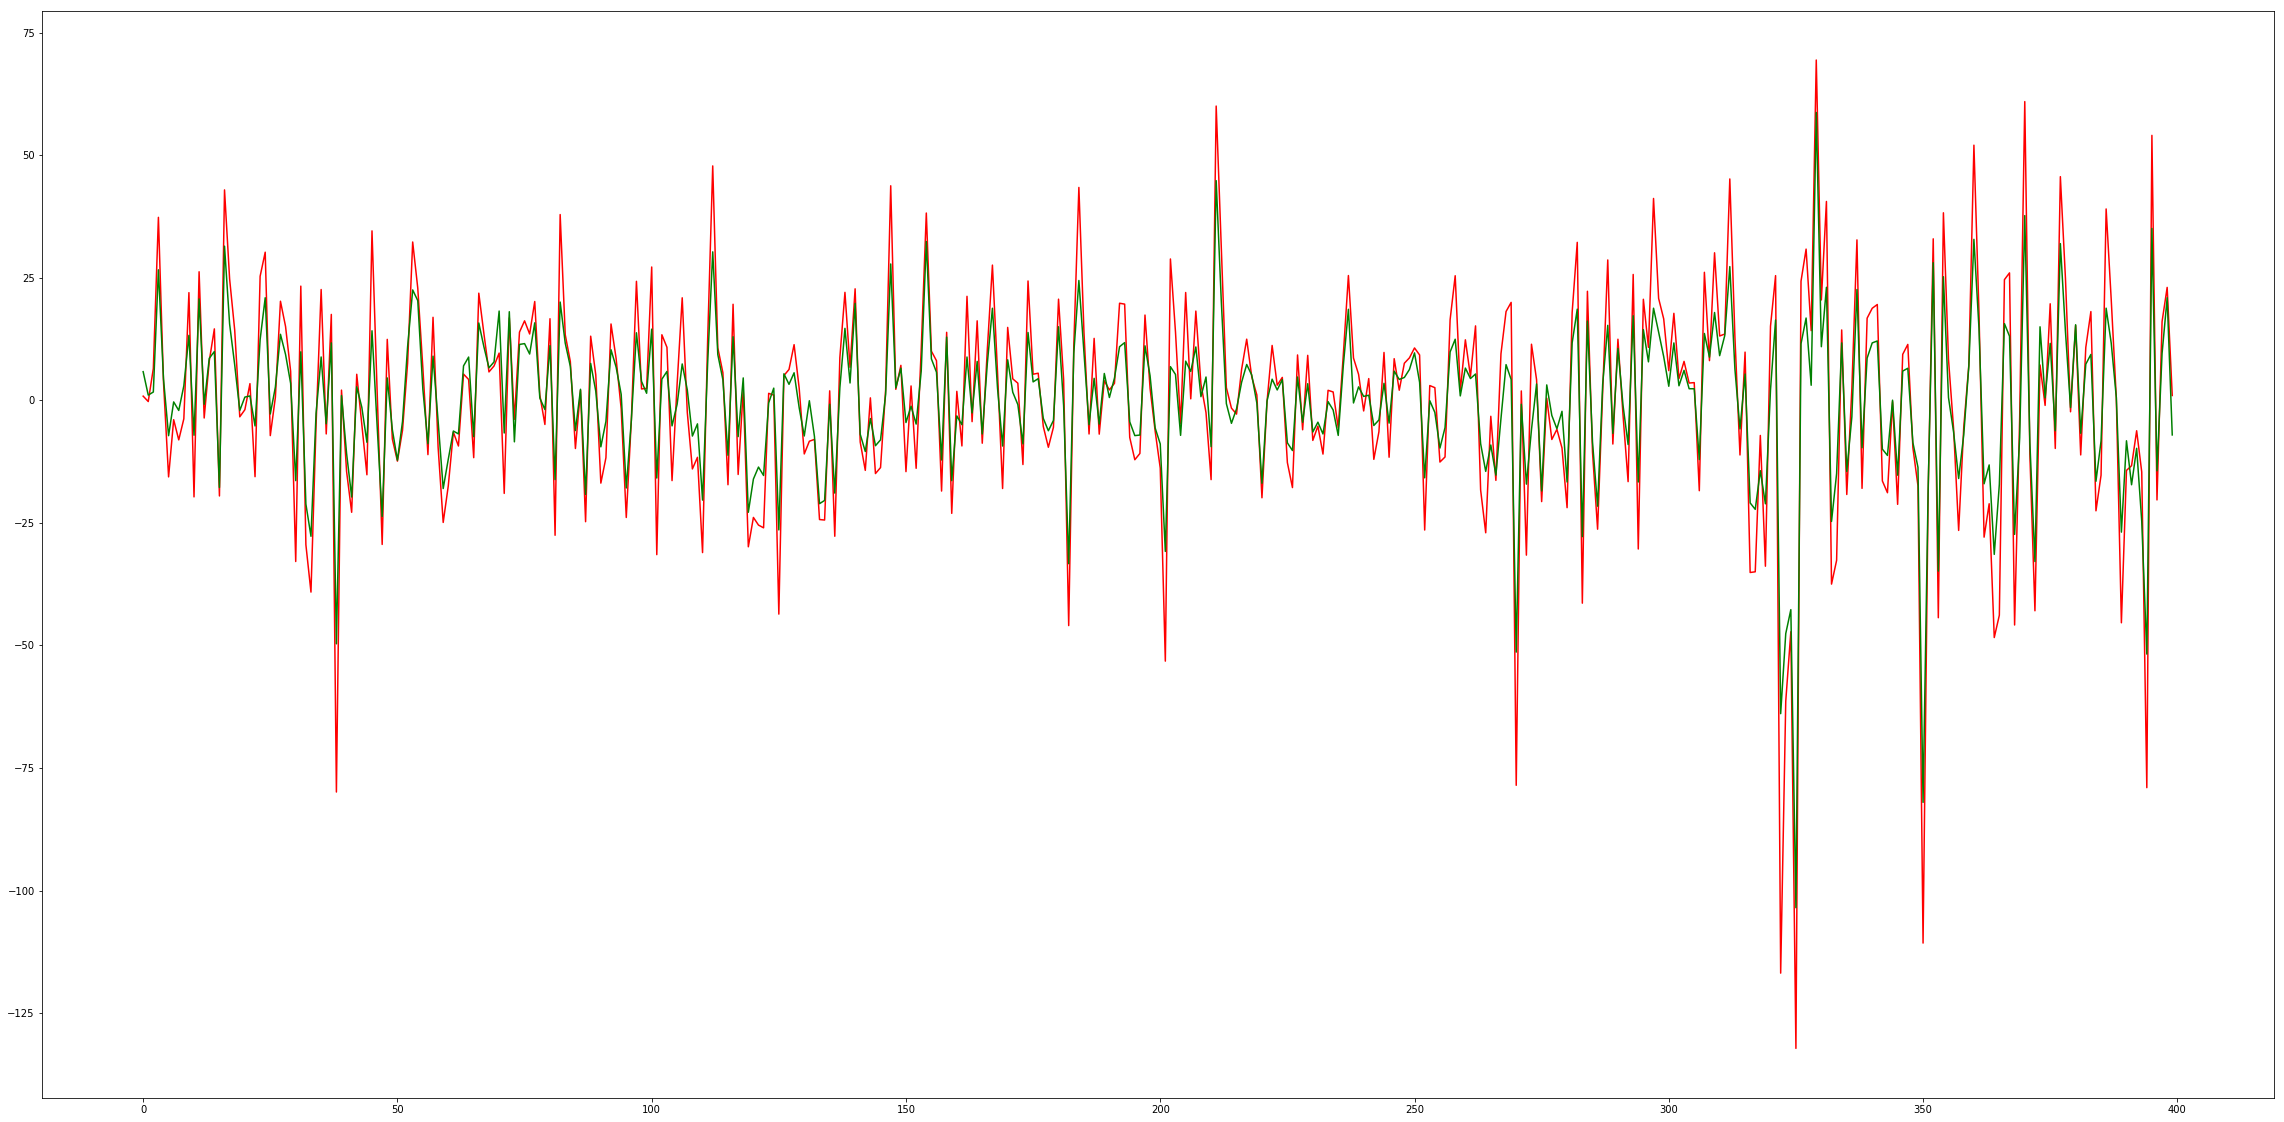

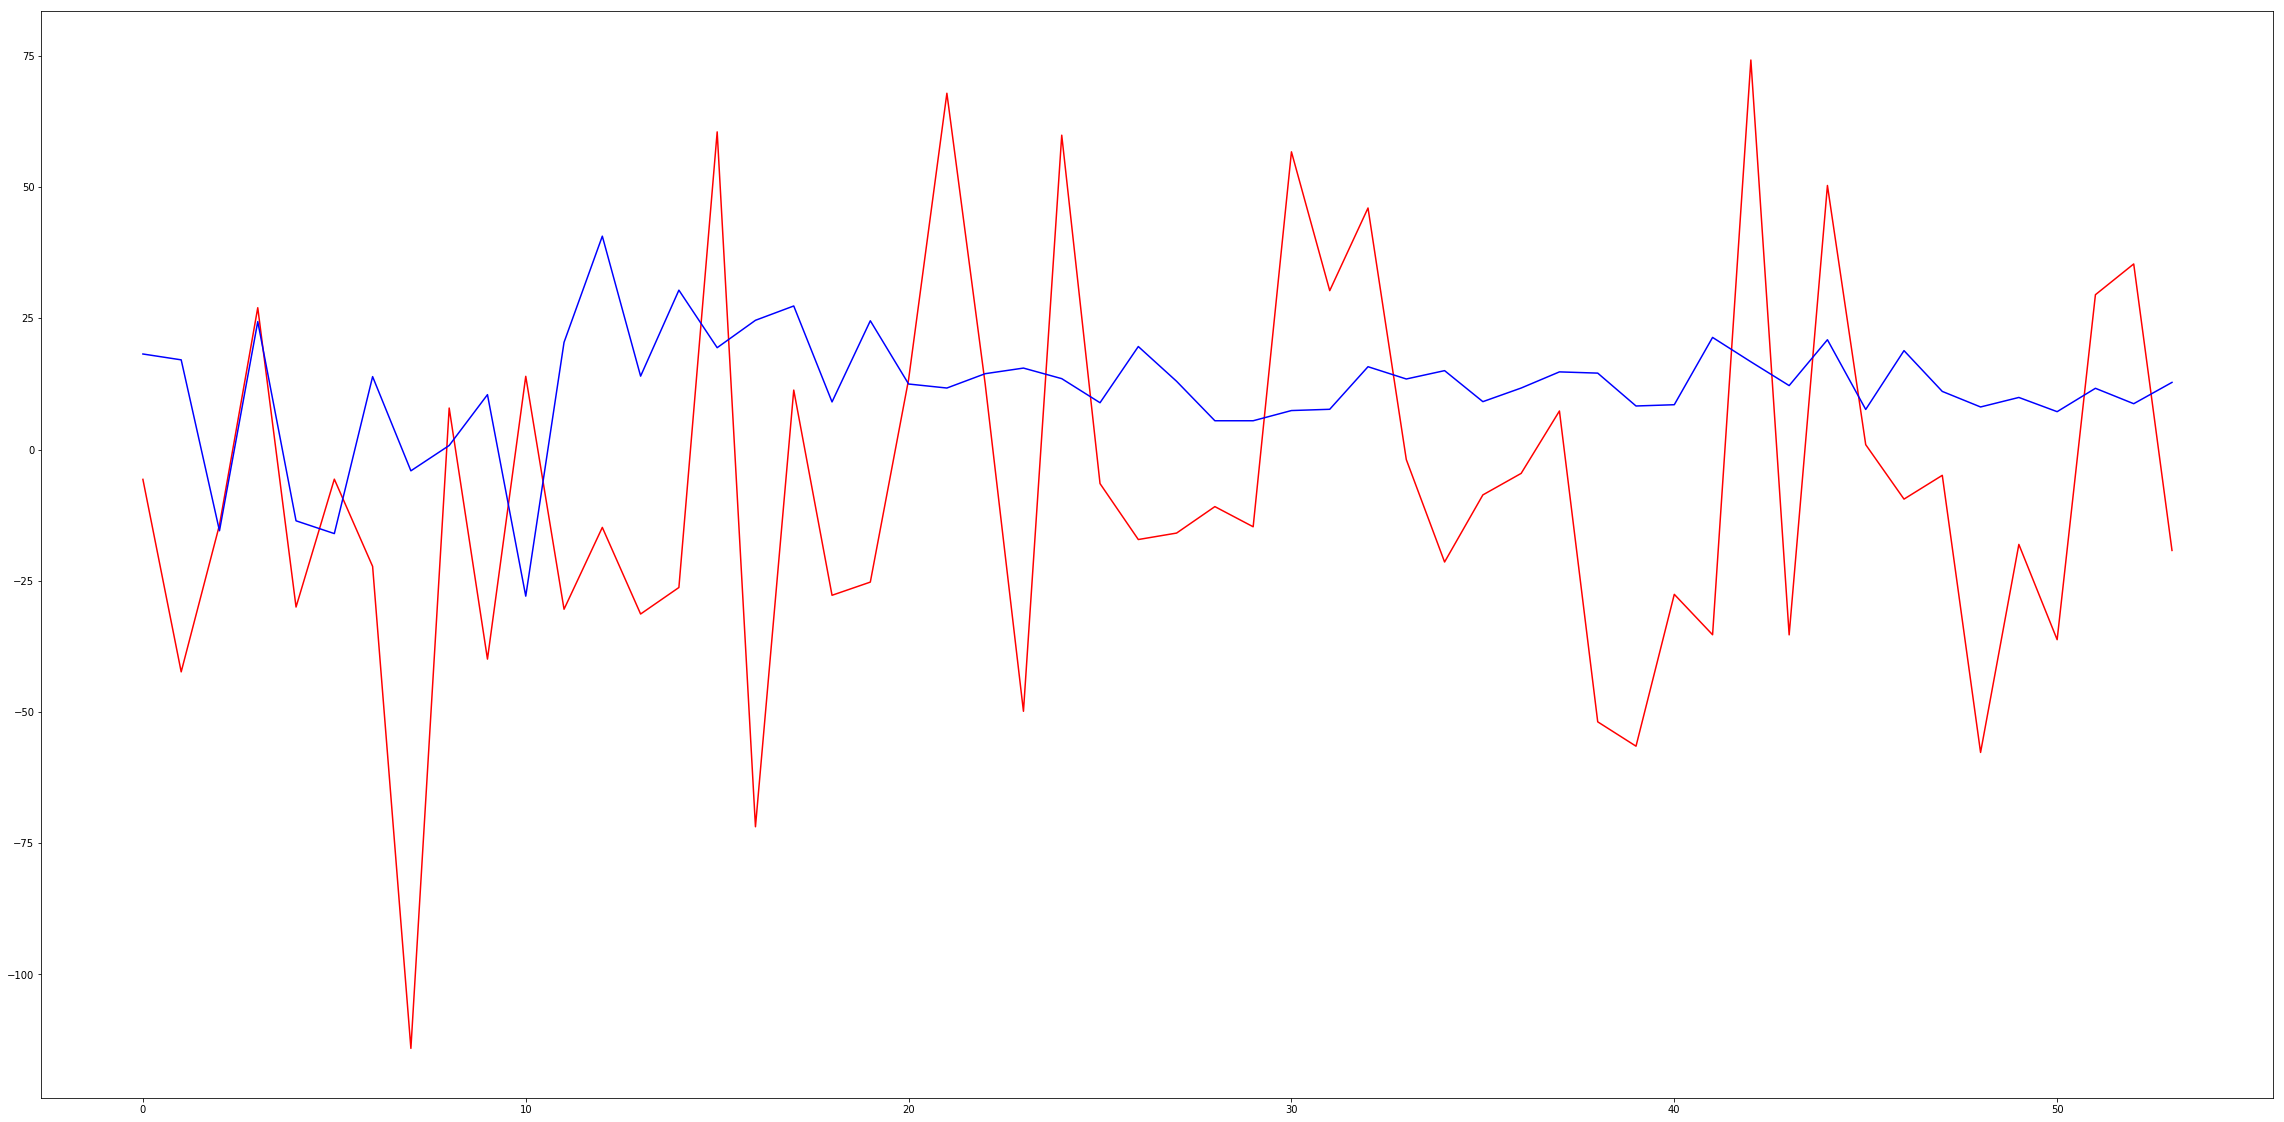

In [50]:
from sklearn.ensemble import RandomForestRegressor
clfrf=RandomForestRegressor(n_estimators=50)
clfrf.fit(gp_tr,trl)
ptr=clfrf.predict(gp_tr)
ptr=ptr.reshape(-1,1)
btr=abs(ptr-trl)
pbtr=np.mean(btr)

import matplotlib.pyplot as plt 
plt.figure(figsize=(40,20))
plt.plot(trl,color='red')
plt.plot(ptr,color='green')
plt.show()
pbtr

pts=clfrf.predict(gp_ts)
pts=pts.reshape(-1,1)
bts=abs(pts-tsl)
pbts=np.mean(bts)



plt.figure(figsize=(40,20))
plt.plot(tsl,color='red')
plt.plot(pts,color='blue')
plt.show()

In [51]:
pbtr

6.616054999999994

In [52]:
pbts

35.459559259259215

In [53]:
gp_tr.shape

(400, 25)

In [57]:
dftr.iloc[:5,:15]

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,open1,high1
31,3056.99,3064.79,3063.81,3043.18,1553737.00,2.46,0.08,3059.410,3026.669,3032.048,1559897.20,1365153.53,1382657.08,3064.69,3068.81
32,3064.69,3068.81,3041.17,3033.75,1637332.62,-22.64,-0.74,3058.016,3032.743,3029.309,1567261.52,1384556.50,1391581.82,3037.40,3084.19
33,3037.40,3084.19,3083.88,3037.40,1820424.62,42.71,1.40,3061.742,3041.314,3029.561,1596799.45,1444897.51,1402256.59,3085.75,3096.22
34,3085.75,3096.22,3084.72,3076.77,1824701.38,0.84,0.03,3066.986,3051.000,3032.698,1676752.57,1522741.95,1390485.62,3084.91,3089.68
35,3084.91,3089.68,3084.46,3076.29,1606913.62,-0.26,-0.01,3071.608,3059.598,3035.745,1688621.85,1570219.39,1403137.51,3081.39,3101.85


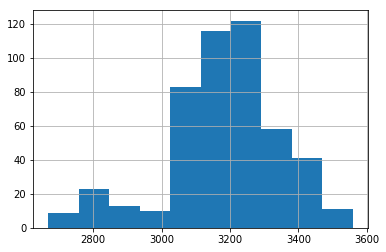

In [58]:
train['close'].hist()

In [59]:
s=np.log1p(train.close)

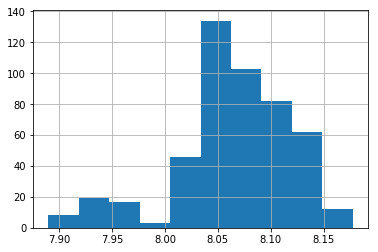

In [60]:
s.hist()

In [63]:
xshg_df.columns

Index(['open', 'high', 'close', 'low', 'volume', 'price_change', 'p_change',
       'ma5', 'ma10', 'ma20', 'v_ma5', 'v_ma10', 'v_ma20'],
      dtype='object')